In [3]:
import glob
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import linalg as la
from scipy.signal import resample
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import gc

In [4]:
train_loc = "TIMIT/TRAIN/*"
train_data = {"raw_signal": [], "mel": [], "label": []}
audios = []
rate = 16000
mel_ = librosa.filters.mel(rate, 2048, n_mels=80)
N = len(glob.glob(train_loc))
for i, f_1 in enumerate(glob.glob(train_loc)):
    print(str(i+1) + "/" + str(N))
    loop = tqdm(total=len(glob.glob(f_1 + '/*')), position=0, leave=False)
    for f_2 in glob.glob(f_1 + '/*'):
        wav_files = glob.glob(f_2 + '/*.WAV')
        for wav_file in wav_files:
            f_name = wav_file.split('/')[-1].split('.')[0]
            phn_file = f_2 + '/' + f_name + '.PHN'
            phones = open(phn_file, 'r').read()
            signal, rate = librosa.load(wav_file, sr=None)
            audio = signal
            for line in phones.split('\n'):
                segment = line.split()
                if len(segment) == 3:
                    start = int(segment[0])
                    end = int(segment[1])
                    phoneme = segment[2]
                    sample = signal[start:end]
                    spectrum = np.log(np.abs(sp.fft(sample))[:len(sample)//2])
                    spectrum = resample(spectrum, 1025)
                    mel = np.dot(mel_, spectrum)
                    train_data["raw_signal"].append(sample)
                    train_data["mel"].append(mel)
                    train_data["label"].append(phoneme)
        loop.update(1)
    loop.close()

  3%|▎         | 1/38 [00:00<00:06,  5.39it/s]

1/8


/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2264: RuntimeWarning: invalid value encountered in multiply
  y = fftpack.ifft(Y, axis=axis) * (float(num) / float(Nx))
  1%|▏         | 1/76 [00:00<00:10,  7.37it/s] 

2/8


 78%|███████▊  | 59/76 [00:11<00:02,  6.48it/s]/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2259: RuntimeWarning: invalid value encountered in true_divide
  Y[tuple(sl)] /= 2  # halve the component at -N/2
  0%|          | 0/76 [00:00<?, ?it/s]         

3/8


  1%|▏         | 1/68 [00:00<00:10,  6.50it/s] 

4/8


  0%|          | 0/70 [00:00<?, ?it/s]         

5/8


  3%|▎         | 1/35 [00:00<00:05,  5.70it/s] 

6/8


  0%|          | 0/77 [00:00<?, ?it/s]         

7/8


  5%|▍         | 1/22 [00:00<00:03,  6.10it/s] 

8/8


In [5]:
test_loc = "TIMIT/TEST/*"
test_data = {"raw_signal": [], "mel": [], "label": []}
audios = []
rate = 16000
mel_ = librosa.filters.mel(rate, 2048, n_mels=80)
N = len(glob.glob(test_loc))
for i, f_1 in enumerate(glob.glob(test_loc)):
    print(str(i+1) + "/" + str(N))
    loop = tqdm(total=len(glob.glob(f_1 + '/*')), position=0, leave=False)
    for f_2 in glob.glob(f_1 + '/*'):
        wav_files = glob.glob(f_2 + '/*.WAV')
        for wav_file in wav_files:
            f_name = wav_file.split('/')[-1].split('.')[0]
            phn_file = f_2 + '/' + f_name + '.PHN'
            phones = open(phn_file, 'r').read()
            signal, rate = librosa.load(wav_file, sr=None)
            audio = signal
            for line in phones.split('\n'):
                segment = line.split()
                if len(segment) == 3:
                    start = int(segment[0])
                    end = int(segment[1])
                    phoneme = segment[2]
                    sample = signal[start:end]
                    spectrum = np.log(np.abs(sp.fft(sample))[:len(sample)//2])
                    spectrum = resample(spectrum, 1025)
                    mel = np.dot(mel_, spectrum)
                    test_data["raw_signal"].append(sample)
                    test_data["mel"].append(mel)
                    test_data["label"].append(phoneme)
        loop.update(1)
    loop.close()

  9%|▉         | 1/11 [00:00<00:01,  5.27it/s]

1/8


  4%|▍         | 1/26 [00:00<00:03,  7.19it/s] 

2/8


 35%|███▍      | 9/26 [00:01<00:02,  6.13it/s]/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2259: RuntimeWarning: invalid value encountered in true_divide
  Y[tuple(sl)] /= 2  # halve the component at -N/2
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2264: RuntimeWarning: invalid value encountered in multiply
  y = fftpack.ifft(Y, axis=axis) * (float(num) / float(Nx))
  4%|▍         | 1/26 [00:00<00:02,  8.65it/s] 

3/8


  3%|▎         | 1/32 [00:00<00:05,  5.29it/s] 

4/8


  0%|          | 0/28 [00:00<?, ?it/s]         

5/8


  9%|▉         | 1/11 [00:00<00:01,  7.01it/s] 

6/8


  4%|▍         | 1/23 [00:00<00:03,  5.70it/s] 

7/8


  9%|▉         | 1/11 [00:00<00:01,  7.14it/s] 

8/8


In [6]:
data = pd.DataFrame(np.vstack(train_data["mel"]))
data["phoneme"] = train_data["label"]
data = data.dropna()
data.phoneme = data.phoneme.astype('category')
X_train = data.drop(columns=["phoneme"]).values
y_train = data.phoneme.values.codes

In [7]:
data = pd.DataFrame(np.vstack(test_data["mel"]))
data["phoneme"] = test_data["label"]
data = data.dropna()
data.phoneme = data.phoneme.astype('category')
X_test = data.drop(columns=["phoneme"]).values
y_test = data.phoneme.values.codes

In [9]:
class TimitMelDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TimitMelClassifier(nn.Module):
    def __init__(self):
        super(TimitMelClassifier, self).__init__()
        embedding_dim = 80
        output_dim = 61
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, inp):
        return self.net(inp)

In [10]:
def calc_accuracy(y_hat, y_truth):
    return sum(y_hat.argmax(dim=1) == y_truth.long()).item() / len(y_truth)

batch_size = 128
update_every_batch = 20
epochs = 200
eta = 1e-4

mel_train_dataset = TimitMelDataset(X_train, y_train)
mel_train_dataloader = DataLoader(mel_train_dataset, 
                                  batch_size=batch_size, 
                                  shuffle=True)
model = TimitMelClassifier()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta)
losses = []
accuracies = []
accuracy = np.nan
for e in range(epochs):
    loop = tqdm(total=len(mel_train_dataloader) // update_every_batch, position=0, leave=False)
    sum_loss = 0
    for batch, (x, y_truth) in enumerate(mel_train_dataloader):
        optimizer.zero_grad()
        y_hat = model(x.float())
        loss = objective(y_hat, y_truth.long())
        loss.backward()
        optimizer.step()
        sum_loss += loss
        #loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.4f}'.format(e, loss, accuracy))
        if batch % update_every_batch == 0 and batch!=0:
            accuracy = calc_accuracy(y_hat, y_truth)
            ave_loss = sum_loss / update_every_batch
            sum_loss = 0
            loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.4f}'.format(e, loss, accuracy))
            loop.update(1)
            losses.append(ave_loss)
            accuracies.append(accuracy)
    loop.close()

In [1]:
x1, y1 = next(iter(mel_train_dataloader))
model = TimitMelClassifier()
y_hat = model(x1.float())
y_hat.shape

NameError: name 'mel_train_dataloader' is not defined

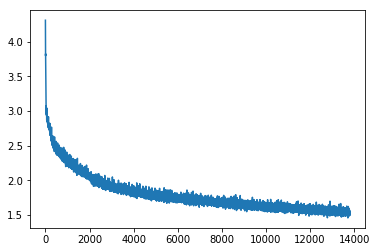

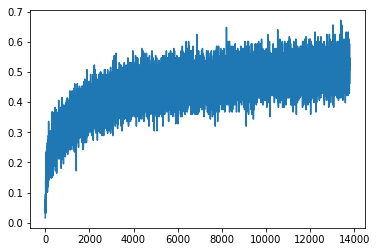

In [11]:
plt.plot(losses)
plt.show()
plt.plot(accuracies)
plt.show()

In [12]:
y_pred = model(torch.tensor(X_test).float())
y_pred = y_pred.argmax(dim=1)
sum(y_pred.numpy() == y_test) / len(y_test)

0.44874093708583457

In [45]:
y_pred = np.array([])
for i in range(int(len(X_test)/batch_size) + 1):
    curr_pred = model(torch.tensor(X_test[i*batch_size:(i+1)*batch_size]).float().unsqueeze(1))
    curr_pred = curr_pred.argmax(dim=1)
    y_pred = np.concatenate([y_pred, curr_pred.numpy()]).astype(int)

In [46]:
sum(y_pred == y_test) / len(y_test)

0.3887892726280502